# Inicialização

In [1]:
import psycopg2
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import scipy

#import warnings
#warnings.filterwarnings("ignore")

In [2]:
dict_connect = {
    "dbname" : "lista4",
    "user" : "postgres",
    "password": "123321",
    "host": "localhost"
}
conn = psycopg2.connect(**dict_connect)
df = pd.read_sql('SELECT * FROM tb_whatsapp_messages', con=conn)
df.info()

C:\Users\Pichau\AppData\Local\Temp\ipykernel_9828\255694495.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('SELECT * FROM tb_whatsapp_messages', con=conn)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407957 entries, 0 to 407956
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      407957 non-null  int64         
 1   date_message            407957 non-null  datetime64[ns]
 2   id_member_anonymous     407957 non-null  object        
 3   ddi                     407957 non-null  object        
 4   ddd                     406311 non-null  object        
 5   country                 407866 non-null  object        
 6   country_iso3            407866 non-null  object        
 7   state                   406311 non-null  object        
 8   id_group_anonymous      407957 non-null  object        
 9   media                   185568 non-null  object        
 10  media_type              187528 non-null  object        
 11  media_url               132949 non-null  object        
 12  has_media               407957

# Tratamento dos dados

## Filtrando as colunas úteis relacionadas ao texto

In [3]:
df = df[["text_content_anonymous", "media_url", "trava_zap", "has_media", "has_media_url", "score_sentiment", "score_misinformation"]]
df.head()

,text_content_anonymous,media_url,trava_zap,has_media,has_media_url,score_sentiment,score_misinformation
0,None,None,False,True,False,NaN,NaN
1,Vou ali,None,False,False,False,0.0000,NaN
2,Jovem vai a sessão parlamentar na câmara dos v...,https://www.noticias-e-politica.com/2023/08/jo...,False,False,True,0.6371,0.001867
3,Jovem vai a sessão parlamentar na câmara dos v...,https://www.noticias-e-politica.com/2023/08/jo...,False,False,True,0.6371,0.001867
4,Jovem vai a sessão parlamentar na câmara dos v...,https://www.noticias-e-politica.com/2023/08/jo...,False,False,True,0.6371,0.001867


## Removendo NaNs

In [4]:
print(df.shape[0])
df = df[ (~df.text_content_anonymous.isna()) & (df.text_content_anonymous != "None") ]
print(df.shape[0])

df

407957
269473


,text_content_anonymous,media_url,trava_zap,has_media,has_media_url,score_sentiment,score_misinformation
1,Vou ali,None,False,False,False,0.0000,NaN
2,Jovem vai a sessão parlamentar na câmara dos v...,https://www.noticias-e-politica.com/2023/08/jo...,False,False,True,0.6371,0.001867
3,Jovem vai a sessão parlamentar na câmara dos v...,https://www.noticias-e-politica.com/2023/08/jo...,False,False,True,0.6371,0.001867
4,Jovem vai a sessão parlamentar na câmara dos v...,https://www.noticias-e-politica.com/2023/08/jo...,False,False,True,0.6371,0.001867
5,*Dilma merece pedido de desculpas por impeachm...,None,False,False,False,0.4019,NaN
...,...,...,...,...,...,...,...
407949,*Colisão no cruzamento do perímetro urbano da ...,https://surgiu.com.br/2023/11/18/colisao-no-cr...,False,False,True,0.6369,0.001697
407952,Vamos divulgar. Eles estão pedindo a nossa par...,None,False,True,False,0.8834,0.507464
407953,*Vejam a desgraça que o governo Lula está faze...,None,False,True,False,-0.7351,0.962875
407954,*CONFIRA O CALENDARIO DO BOLSA FAMILIA PARA ES...,None,False,False,False,-0.3254,NaN


## Colunas score_sentiment e score_misinformation

In [5]:
df.loc[:, "score_misinformation"] = df["score_misinformation"].fillna(df["score_misinformation"].quantile(0.5))

In [6]:
df.describe()

,score_sentiment,score_misinformation
count,269473.000000,269473.000000
mean,-0.055079,0.212823
std,0.401148,0.147730
min,-0.999800,0.000002
25%,-0.282400,0.187924
50%,0.000000,0.187924
75%,0.000000,0.187924
max,0.999700,1.000000


## Adicionando o Target e removendo duplicatas

In [7]:
texto_target = df.groupby("text_content_anonymous")["text_content_anonymous"].count()
df = df.merge(texto_target, left_on = "text_content_anonymous", right_index = True)
df = df.rename(columns = {"text_content_anonymous_y": "viralizacao"})
df = df.drop(columns = "text_content_anonymous_x")

In [8]:
print(df.shape[0])
df = df[ ~(df.text_content_anonymous.duplicated()) ] 
print(df.shape[0])

df

269473
164661


,text_content_anonymous,media_url,trava_zap,has_media,has_media_url,score_sentiment,score_misinformation,viralizacao
1,Vou ali,None,False,False,False,0.0000,0.187924,1
2,Jovem vai a sessão parlamentar na câmara dos v...,https://www.noticias-e-politica.com/2023/08/jo...,False,False,True,0.6371,0.001867,4
5,*Dilma merece pedido de desculpas por impeachm...,None,False,False,False,0.4019,0.187924,4
10,PEGUE-ME SE FOR CAPAZ: Suplente de vereador de...,https://expressopb.com.br/pegue-me-se-for-capa...,False,False,True,-0.1449,0.054578,1
11,https://youtu.be/6krSSrBGuNM?si=RsLsAHcS7O5xDQs8,None,False,False,False,0.0000,0.187924,1
...,...,...,...,...,...,...,...,...
407948,*Acho que você vai adorar este vídeo!*\nhttps:...,https://kwai-video.com/p/ChwHf3Pq,False,False,True,0.7177,0.187924,1
407949,*Colisão no cruzamento do perímetro urbano da ...,https://surgiu.com.br/2023/11/18/colisao-no-cr...,False,False,True,0.6369,0.001697,1
407952,Vamos divulgar. Eles estão pedindo a nossa par...,None,False,True,False,0.8834,0.507464,1
407953,*Vejam a desgraça que o governo Lula está faze...,None,False,True,False,-0.7351,0.962875,1


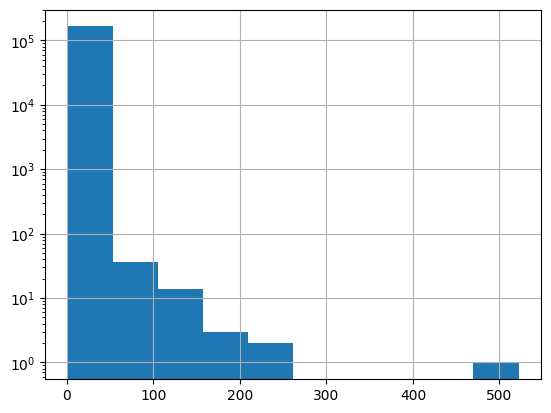

In [9]:
df.viralizacao.hist()
plt.yscale('log')
plt.show()

# Divisão de treino e teste

In [22]:
from sklearn.model_selection import train_test_split

# Diminuindo os dados momentaneamente para testar a pipeline
LIMITAR = 20000
amostra = df.copy().sample(LIMITAR, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(amostra.drop(columns = 'viralizacao'), amostra.viralizacao, test_size=0.4, random_state=42)



# Criação da pipeline
Tentar fazer tudo usando um grid_search na qual cada parâmetro seria da pipeline

- Regularização: model_parametros
- Normalização: normalization_parametros
- Pré-processamento: preprocessing_parametros
- Embeddings: embeddings_parametros
- N-Gramas: embeddings_parametros
- Usar 4 fold cross validation

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin


## Pré-processamento

In [47]:
from urllib.parse import urlparse
import re
import string
import nltk
import emoji
import unidecode
import spacy
from spacy.tokenizer import Tokenizer






def limit_repetitions(text, max_repetitions=3):
    pattern = r"(.)\1{" + str(max_repetitions) + r",}"
    return re.sub(pattern, lambda m: m.group(1) * max_repetitions, text)

def get_root_domain(url):
    parsed_url = urlparse(url)
    root_domain = f"{parsed_url.hostname}"
    return root_domain


def preprocessamento(X):
    texto_usuario = X['text_content_anonymous']
    url = X['media_url']

    # extraindo dominio da url
    url_nova = url.apply(get_root_domain).copy()


    # substituindo os dominios no texto
    for i in texto_usuario.index:
        if url.at[i]:  # Verifica se a URL não é vazia
            texto_usuario.at[i] = texto_usuario.at[i].replace(url.at[i], url_nova.at[i])


    # letras para minusculo
    texto_usuario = texto_usuario.apply(lambda x: x.lower())

    # limitando repetições de caracteres
    texto_usuario = texto_usuario.apply(limit_repetitions)
    
    # emojis
    texto_usuario = texto_usuario.apply(emojis_to_aliases)

    # separando emojis
    texto_usuario = texto_usuario.apply(lambda x: x.replace("::", ": :"))

    # pequeno tratamento
    def insert_space_before_colon(text):
        pattern = r'(?<=[.,!?]):'
        return re.sub(pattern, ' :', text)
    texto_usuario = texto_usuario.apply(insert_space_before_colon)

    # removendo caracteres indesejaveis
    caracteres_permitidos = "abcdefghijklmnopqrstuvwxyzàáâãèéêìíîòóôõùúûç:*_"
    texto_usuario = texto_usuario.apply(lambda x: x.replace("/n", " "))
    verificar_caracteres = lambda texto: any(char in "abcdefghijklmnopqrstuvwxyzàáâãèéêìíîòóôõùúûç" for char in texto)
    texto_usuario = texto_usuario.apply( lambda x: " ".join( (token if verificar_caracteres(token) else "") for token in re.split(r'\s+', x) ) )
    texto_usuario = texto_usuario.apply(lambda x: " ".join( (word[:-1] if word[-1] in ".,!?" else word) for word in x.split()) )
    texto_usuario = texto_usuario.apply(lambda x: " ".join( (word[:-1] if word[-1] in ".,!?" else word) for word in x.split()) )
    texto_usuario = texto_usuario.apply(lambda x: " ".join( (word[:-1] if word[-1] in ".,!?" else word) for word in x.split()) )

    # removendo stop words
    stop_words = nltk.corpus.stopwords.words("portuguese")
    stop_words.remove("não")
    texto_usuario = texto_usuario.apply(lambda x: " ".join( filter(lambda word: word not in stop_words, x.split()) ))

    # lematizacao
    nlp = spacy.load('pt_core_news_sm')
    def custom_tokenizer(nlp):
        return Tokenizer(nlp.vocab, token_match=None)
    nlp.tokenizer = custom_tokenizer(nlp)
    texto_usuario = texto_usuario.apply(lambda x: " ".join(token.lemma_ for token in nlp(x) ))

    # removendo acentuacoes
    texto_usuario = texto_usuario.apply(unidecode.unidecode)
    

    return texto_usuario

def emojis_to_aliases(text):
    return emoji.demojize(text)

exemplos = X_train.sample(5)
textos1 = exemplos.text_content_anonymous
textos2 = preprocessamento(exemplos)
for i in range(len(textos1)):
    print(textos1.iloc[i])
    print("----- VVV -----")
    print(textos2.iloc[i])
    print()

youtu.be
----- VVV -----
youtu.be

Q não falte pólvora em Israel !
----- VVV -----
q nao faltar polvora Israel

Estou reforçando a ajuda que pediram para esse Jovem Senhor. 🙏🙏🙏 Juntos conseguiremos este objetivo.
----- VVV -----
reforcar ajudar pedir jovem senhor :folded_hands: :folded_hands: :folded_hands: junto conseguiremos objetivo

*Esta notícia me deixa triste!*
kwai-video.com
----- VVV -----
*esta noticia deixar triste!* kwai-video.com

ALÔ grande povo! Eu falei. Iam dizer que tinha sido Bolsonaro. 😂😂😂😂😂
----- VVV -----
alo grande povo falar ir dizer ser bolsonaro :face_with_tears_of_joy: :face_with_tears_of_joy: :face_with_tears_of_joy:



In [13]:
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, aplicar_processamento=False):
        self.aplicar_processamento = aplicar_processamento

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.aplicar_processamento:
            X['text_content_anonymous'] = preprocessamento(X)
        return X

preprocessing_step = CustomPreprocessor()

## Embedding

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec


def text_to_vector(text, model):
    words = text.split()
    words = [word for word in words if word in model.wv]
    
    if len(words) == 0:
        return np.zeros(model.vector_size)

    word_vectors = np.array([model.wv[word] for word in words])
    return np.mean(word_vectors, axis=0)


class Embedding(BaseEstimator, TransformerMixin):
    def __init__(self, tipo_embedding = "BOW", n_grams = 1):
        self.tipo_embedding = tipo_embedding
        self.n_grams = n_grams
        self.QNT_FEATURES = 500

    def fit(self, X, y=None):

        if self.tipo_embedding == "BOW":
            self.vetorizador = CountVectorizer(max_features = self.QNT_FEATURES, ngram_range = (1,self.n_grams))
            self.vetorizador.fit(X.iloc[:,0])

        elif self.tipo_embedding == "TF-IDF":
            self.vetorizador = TfidfVectorizer(max_features = self.QNT_FEATURES, ngram_range = (1,self.n_grams))
            self.vetorizador.fit(X.iloc[:,0])

        elif self.tipo_embedding == "WORD2VEC":
            w2v_modelo = Word2Vec(
                sg = 0, # cbow
                window = self.n_grams * 2,
                vector_size  = self.QNT_FEATURES,
                min_count = 3,
                alpha = 0.03,
                min_alpha = 0.007
            )

            textos = X.iloc[:,0]
            lista_lista_tokens = [texto.split() for texto in textos]
            w2v_modelo.build_vocab(lista_lista_tokens, progress_per = 5000)

            w2v_modelo.train(lista_lista_tokens,
                 total_examples = w2v_modelo.corpus_count,
                 epochs = 400,
            )

            self.w2v_modelo = w2v_modelo

        else:
            raise Exception("Este embedding não está implementado ou não existe")
        
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        if self.tipo_embedding == "BOW":
            bag_of_words = self.vetorizador.transform(X.iloc[:,0])
            bow = pd.DataFrame.sparse.from_spmatrix(bag_of_words, columns=self.vetorizador.get_feature_names_out())
            bow.index = X.index
            X = pd.concat([X, bow], axis = 1)
    
        elif self.tipo_embedding == "TF-IDF":
            tf_idf = self.vetorizador.transform(X.iloc[:,0])
            tfidf = pd.DataFrame.sparse.from_spmatrix(tf_idf, columns=self.vetorizador.get_feature_names_out())
            tfidf.index = X.index
            X = pd.concat([X, tfidf], axis = 1)
    
        elif self.tipo_embedding == "WORD2VEC":
            textos = X.iloc[:,0]
            matriz = np.array([text_to_vector(texto, self.w2v_modelo) for texto in textos])
            word2vec = pd.DataFrame(data = matriz, index = X.index, columns = ["w2v_" + str(i) for i in range(1,self.QNT_FEATURES+1)])
            X = pd.concat([X, word2vec], axis = 1)
            
        
        else:
            raise Exception("Este embedding não está implementado ou não existe")

        X = X.drop(X.columns[[0,1]], axis=1)
        return X

embedding_step = Embedding()

## Normalização

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class Normalizer(BaseEstimator, TransformerMixin):
    def __init__(self, tipo_normalizacao = "nenhuma"):
        self.tipo_normalizacao = tipo_normalizacao

    def fit(self, X, y=None):
        if self.tipo_normalizacao == 'nenhuma':
            return self
        elif self.tipo_normalizacao == 'standard':
            scaler = StandardScaler()
        elif self.tipo_normalizacao == 'minmax':
            scaler = MinMaxScaler()
        else:
            raise ValueError(f"Tipo de normalização desconhecido: {self.tipo_normalizacao}")

        scaler.fit(X)
        self.scaler = scaler
        
        return self

    def transform(self, X):
        if self.tipo_normalizacao == 'nenhuma':
            return X
        elif self.tipo_normalizacao == 'standard' or self.tipo_normalizacao == 'minmax':
            return pd.DataFrame( self.scaler.transform(X), index = X.index, columns = X.columns )
        else:
            raise ValueError(f"Tipo de normalização desconhecido: {self.tipo_normalizacao}")


normalization_step = Normalizer()

### Modelo/Regularização

In [16]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import ElasticNet, Lasso, Ridge

class CustomRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, regularizacao="Ridge", random_state=None):
        self.regularizacao = regularizacao
        self.random_state = random_state

    def fit(self, X, y):
        if self.regularizacao == "Ridge":
            self.modelo = Ridge(alpha=0.2, random_state=self.random_state)
        elif self.regularizacao == "Lasso":
            self.modelo = Lasso(alpha=1, random_state=self.random_state)
        elif self.regularizacao == "ElasticNet":
            self.modelo = ElasticNet(alpha=0.2, random_state=self.random_state)
        else:
            raise ValueError(f"Tipo de regularização desconhecido: {self.regularizacao}")
        
        self.modelo.fit(X, y)
        return self

    def predict(self, X):
        return self.modelo.predict(X)

    def score(self, X, y):
        return self.modelo.score(X, y)

model_step = CustomRegressor()

## Pipeline

In [17]:
# Função para ignorar um step se for None
def skip_if_none(step):
    return step if step is not None else FunctionTransformer()


pipeline = Pipeline([
    ('preprocessing', skip_if_none(preprocessing_step)),
    ('embedding', skip_if_none(embedding_step)),
    ('normalization', skip_if_none(normalization_step)),
    ('model', skip_if_none(model_step))
])

In [18]:
X_train.shape

(12000, 7)

In [19]:
pipeline.set_params(preprocessing__aplicar_processamento = True)
pipeline.set_params(embedding__tipo_embedding = "BOW")
pipeline.set_params(embedding__n_grams = 3)
pipeline.set_params(normalization__tipo_normalizacao = "minmax")
pipeline.set_params(model__regularizacao = "ElasticNet")

Pipeline(steps=[('preprocessing',
                 CustomPreprocessor(aplicar_processamento=True)),
                ('embedding', Embedding(n_grams=3)),
                ('normalization', Normalizer(tipo_normalizacao='minmax')),
                ('model', CustomRegressor(regularizacao='ElasticNet'))])

In [20]:
#pipeline.fit(X_train, y_train)
#pipeline.transform(X_train)
#pipeline.transform(X_test)

In [21]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

C:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [22]:
y_pred[:10]

array([1.633, 1.633, 1.633, 1.633, 1.633, 1.633, 1.633, 1.633, 1.633,
       1.633])

In [23]:
(y_test - y_pred).abs().median()

0.633

# Grid Search

In [24]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    "preprocessing__aplicar_processamento": [True, False],
    "embedding__tipo_embedding": ["BOW", "TF-IDF", "WORD2VEC"],
    "embedding__n_grams": [1,2,3],
    "normalization__tipo_normalizacao": ["nenhuma", "minmax", "standard"],
    "model__regularizacao": ["Ridge", "Lasso", "ElasticNet"]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=6, scoring = "neg_mean_squared_error", verbose=1)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        CustomPreprocessor(aplicar_processamento=True)),
                                       ('embedding', Embedding(n_grams=3)),
                                       ('normalization',
                                        Normalizer(tipo_normalizacao='minmax')),
                                       ('model',
                                        CustomRegressor(regularizacao='ElasticNet'))]),
             n_jobs=6,
             param_grid={'embedding__n_grams': [1, 2, 3],
                         'embedding__tipo_embedding': ['BOW', 'TF-IDF',
                                                       'WORD2VEC'],
                         'model__regularizacao': ['Ridge', 'Lasso',
                                                  'ElasticNet'],
                         'normalization__tipo_normalizacao': ['nenhuma',
                                                              'minmax',
                                                              'standard'],
                         'preprocessing__aplicar_processamento': [True, False]},
             scoring='neg_mean_squared_error', verbose=1)

In [25]:
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)
print("Melhor pontuação:")
print(grid_search.best_score_)

Melhores parâmetros encontrados:
{'embedding__n_grams': 1, 'embedding__tipo_embedding': 'TF-IDF', 'model__regularizacao': 'Ridge', 'normalization__tipo_normalizacao': 'nenhuma', 'preprocessing__aplicar_processamento': False}
Melhor pontuação:
-9.374879853627546


In [26]:
from joblib import dump

print("\nResultados de todos os parâmetros:")
melhor_modelo = grid_search.best_estimator_
dump(melhor_modelo, 'melhor_modelo.pkl')

matriz_resultados = []
for params, mean_score, scores in zip(grid_search.cv_results_['params'], 
                                      grid_search.cv_results_['mean_test_score'],
                                      grid_search.cv_results_['std_test_score']):

    matriz_resultados.append( [*params.values(), mean_score, scores] )
df_resultados = pd.DataFrame(matriz_resultados, columns = [*grid_search.cv_results_['params'][0].keys(), "mean_test_score", "std_test_score" ])
df_resultados.to_csv("resultados_modelos.csv")
df_resultados.nlargest(10, columns = "mean_test_score")


Resultados de todos os parâmetros:


,embedding__n_grams,embedding__tipo_embedding,model__regularizacao,normalization__tipo_normalizacao,preprocessing__aplicar_processamento,mean_test_score,std_test_score
19,1,TF-IDF,Ridge,nenhuma,False,-9.374880,4.043944
126,3,TF-IDF,Ridge,nenhuma,True,-9.382992,4.030113
21,1,TF-IDF,Ridge,minmax,False,-9.384383,4.038240
73,2,TF-IDF,Ridge,nenhuma,False,-9.386515,4.130564
23,1,TF-IDF,Ridge,standard,False,-9.395694,4.036738
75,2,TF-IDF,Ridge,minmax,False,-9.399293,4.119440
128,3,TF-IDF,Ridge,minmax,True,-9.402810,4.022283
72,2,TF-IDF,Ridge,nenhuma,True,-9.411712,3.994075
77,2,TF-IDF,Ridge,standard,False,-9.418998,4.116393
70,2,BOW,ElasticNet,standard,True,-9.419621,4.200669


# Análise do melhor modelo

In [20]:
from joblib import load

melhor_modelo = load('melhor_modelo.pkl')


## Estatísticas do target

In [23]:
y_pred = melhor_modelo.predict(X_test)

print("Target Real: ")
print(pd.Series(y_test).describe())

print()
print("Target Predito: ")
print(pd.Series(y_pred).describe())

Target Real: 
count    8000.000000
mean        1.625875
std         2.712209
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       103.000000
Name: viralizacao, dtype: float64

Target Predito: 
count    8000.000000
mean        1.646691
std         1.341328
min        -3.951846
25%         1.167765
50%         1.402499
75%         1.693517
max        15.670045
dtype: float64


C:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


## Métricas

In [24]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error

print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

MSE: 6.103410852301263
RMSE: 2.4705082174122115
MAE: 0.8361684607510323


## Resíduos

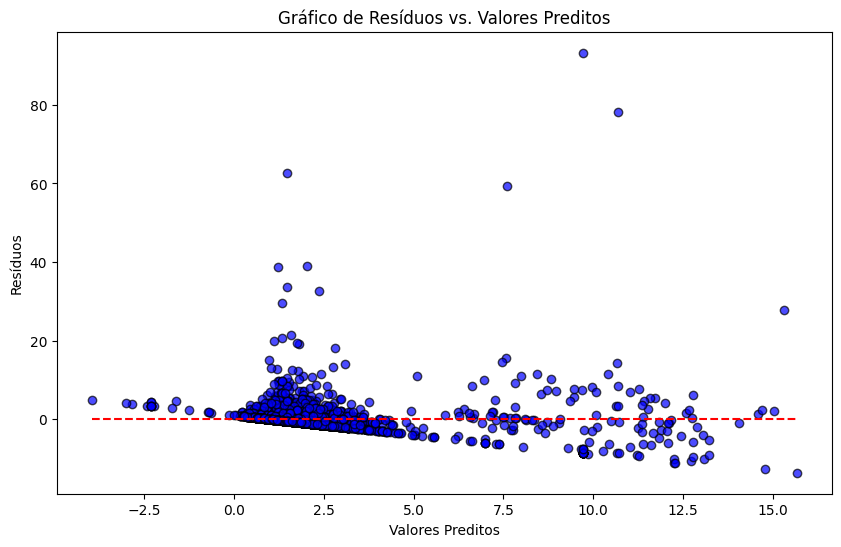

In [25]:
residuals = y_test - y_pred

# Gráfico de Resíduos vs. Valores Preditos
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color="blue", edgecolors='k', alpha=0.7)
plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), color="red", linestyles="dashed")
plt.title("Gráfico de Resíduos vs. Valores Preditos")
plt.xlabel("Valores Preditos")
plt.ylabel("Resíduos")
plt.show()


## Importância de atributos

In [26]:
model = melhor_modelo.named_steps["model"].modelo
coefs = model.coef_

amostra = melhor_modelo.named_steps["preprocessing"].transform(X_test)
amostra = melhor_modelo.named_steps["embedding"].transform(amostra)
amostra = melhor_modelo.named_steps["normalization"].transform(amostra)

feature_importance = pd.DataFrame({
    'Feature': amostra.columns,
    'Coefficient': coefs,
    'Importance (abs)': np.abs(coefs)
})

#feature_importance = feature_importance.sort_values(by='Importance (abs)', ascending=False)
feature_importance.head(5)

,Feature,Coefficient,Importance (abs)
0,trava_zap,0.000000,0.000000
1,has_media,0.143970,0.143970
2,has_media_url,-0.017119,0.017119
3,score_sentiment,-0.028440,0.028440
4,score_misinformation,0.430973,0.430973


In [27]:
feature_importance.nlargest(10, columns = "Importance (abs)")

,Feature,Coefficient,Importance (abs)
346,pensandodireita,30.231963,30.231963
366,portaltocanews,21.588381,21.588381
426,si,-13.242015,13.242015
500,youtu,6.980002,6.980002
319,obs,5.818828,5.818828
69,be,5.341804,5.341804
43,amigos,4.992284,4.992284
425,shorts,4.751788,4.751788
257,live,4.382960,4.382960
501,youtube,4.115090,4.115090
